<a href="https://colab.research.google.com/github/sdariza/MLP-Weather-Prediction/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install cdo
!sudo apt-get upgrade cdo
!pip install netCDF4
!pip install iris-grib
!pip install cdo
!pip install --upgrade cdo
!pip install --upgrade netCDF4
!wget https://raw.githubusercontent.com/sdariza/tesis-cnn/master/downloadData

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,776 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,255 kB]
Get:14 http://archiv

In [ ]:
!bash downloadData

Ingresa el año de inicio: 2018
--2023-06-10 22:39:37--  https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/pressure/air.2018.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323395968 (308M) [application/x-netcdf]
Saving to: ‘data/air/air.2018.nc’

air.2018.nc         100%[===================>] 308.41M  16.3MB/s    in 20s     

2023-06-10 22:39:58 (15.2 MB/s) - ‘data/air/air.2018.nc’ saved [323395968/323395968]

--2023-06-10 22:39:58--  https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/pressure/air.2019.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323361342 (308M) [application/x-netcdf]
Saving to: ‘data/air/air.2019.n

In [ ]:
import glob
from cdo import Cdo
import iris
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
cdo = Cdo()
import matplotlib.pyplot as plt
np.random.seed(73)
tf.random.set_seed(73)

In [ ]:
variable_paths = glob.glob('data/*')
variable_paths

['data/air']

In [ ]:
for variable_path in variable_paths:
  file_paths = glob.glob(f'{variable_path}/*.nc')
  variable = variable_path.split('/')[-1]
  try:
    cdo.mergetime(input=file_paths, output=f'{variable}-mergetime.nc')
  except:
    print(f'No worries! {variable} merged!!')

Error in calling operator mergetime with:
>>> cdo -O -s -mergetime data/air/air.2019.nc data/air/air.2021.nc data/air/air.2018.nc data/air/air.2023.nc data/air/air.2020.nc data/air/air.2022.nc air-mergetime.nc<<<
STDOUT:
STDERR:free(): invalid pointer
Aborted (core dumped)

No worries! air merged!!


In [ ]:
nc_paths_merged = glob.glob('*.nc')
nc_paths_merged

['air-mergetime.nc']

In [ ]:
cube = iris.load_cube('air-mergetime.nc')
cube

<iris 'Cube' of air_temperature / (degK) (time: 7908; air_pressure: 17; latitude: 73; longitude: 144)>

In [ ]:
query_H0 = iris.Constraint(time = lambda cell : cell.point.hour == 0, air_pressure = lambda cell: cell == 1000)
query_H6 = iris.Constraint(time = lambda cell : cell.point.hour == 6, air_pressure = lambda cell: cell == 1000)

In [ ]:
X = cube.extract(query_H0).data.data -273.15
Y = cube.extract(query_H6).data.data -273.15

In [ ]:
X.shape

(1977, 73, 144)

In [ ]:
Y.shape

(1977, 73, 144)

In [ ]:
model = tf.keras.models.Sequential(name='CNN-Weather-Forecast-encoder')
model.add(tf.keras.Input(shape=(73,144,1)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2), padding='same'))

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(512))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
# model.add(tf.keras.layers.Dense(256))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
# model.add(tf.keras.layers.Dense(512))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
# model.add(tf.keras.layers.Dense(units=10*18*32))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# model.add(tf.keras.layers.Reshape(target_shape=(10,18,32)))

model.add(tf.keras.layers.Conv2DTranspose(filters=1024, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(3,3), strides=2,padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Cropping2D(cropping=((1,0),(0,0))))
model.add(tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2,padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Cropping2D(cropping=((1,0),(0,0))))
model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2,padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Cropping2D(cropping=((1,0),(0,0))))
model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3),padding='same'))

In [ ]:
model.build(input_shape=(None,73,144,1))
model.summary()

Model: "CNN-Weather-Forecast-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 144, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 73, 144, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 73, 144, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 144, 64)       18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 73, 144, 64)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 73, 144, 64)      256       
 hNormalization)                      

In [ ]:
# Split the data into training, validation, and test sets
split_ratio_train = 0.7
split_ratio_val = 0.2
split_ratio_test = 0.1

In [ ]:
num_samples = len(X)
num_train = int(split_ratio_train * num_samples)
num_val = int(split_ratio_val * num_samples)
num_test = num_samples - num_train - num_val

In [ ]:
train_data = X[:num_train]
val_data = X[num_train:num_train+num_val]
test_data = X[num_train+num_val:]

In [ ]:
train_labels = Y[:num_train]
val_labels = Y[num_train:num_train+num_val]
test_labels = Y[num_train+num_val:]

In [ ]:
# Reshape the data to match the expected input shape of the model
train_data = train_data.reshape(-1, 73, 144, 1)
val_data = val_data.reshape(-1, 73, 144, 1)
test_data = test_data.reshape(-1, 73, 144, 1)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError() ,metrics=tf.keras.losses.MeanAbsolutePercentageError())

In [ ]:
train_labels = train_labels.reshape(-1, 73, 144, 1)
val_labels = val_labels.reshape(-1, 73, 144, 1)
test_labels = test_labels.reshape(-1, 73, 144, 1)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
with tf.device('/device:GPU:0'):
  history = model.fit(train_data,train_labels,epochs=150,shuffle=True, validation_data=(val_data,val_labels), batch_size=10, verbose=1, callbacks=[checkpoint,early_stopping])

Epoch 1/150
139/139 [==============================] - ETA: 0s - loss: 75.5681 - mean_absolute_percentage_error: 160.8155
Epoch 1: val_loss improved from inf to 49.48456, saving model to best_model.h5
139/139 [==============================] - 48s 157ms/step - loss: 75.5681 - mean_absolute_percentage_error: 160.8155 - val_loss: 49.4846 - val_mean_absolute_percentage_error: 118.5366
Epoch 2/150
139/139 [==============================] - ETA: 0s - loss: 8.9610 - mean_absolute_percentage_error: 60.2802
Epoch 2: val_loss improved from 49.48456 to 20.27520, saving model to best_model.h5
139/139 [==============================] - 19s 133ms/step - loss: 8.9610 - mean_absolute_percentage_error: 60.2802 - val_loss: 20.2752 - val_mean_absolute_percentage_error: 81.6746
Epoch 3/150
139/139 [==============================] - ETA: 0s - loss: 4.2268 - mean_absolute_percentage_error: 41.0605
Epoch 3: val_loss improved from 20.27520 to 6.08244, saving model to best_model.h5
139/139 [==================

In [ ]:
# Evaluate the model on test data # último earlystop
test_loss, test_mape = model.evaluate(test_data, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test MAPE: {test_mape}')

7/7 [==============================] - 6s 359ms/step - loss: 3.2474 - mean_absolute_percentage_error: 30.1340
Test Loss: 3.2474400997161865
Test MAPE: 30.1340274810791


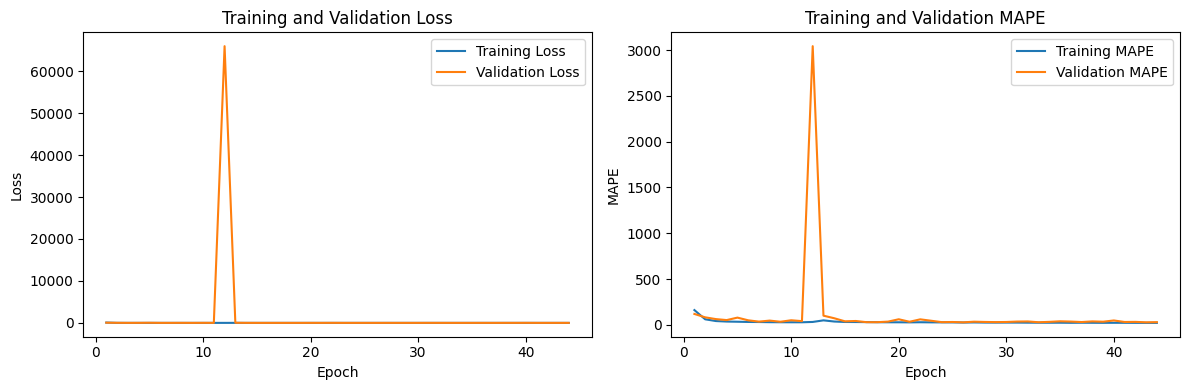

In [ ]:
# Obtener las métricas del entrenamiento y la validación
train_loss = history.history['loss']
train_mape = history.history['mean_absolute_percentage_error']
val_loss = history.history['val_loss']
val_mape = history.history['val_mean_absolute_percentage_error']

# Graficar las métricas
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, np.log(train_loss), label='Training Loss')
plt.plot(epochs, np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('$log(Loss)$')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.log(train_mape), label='Training MAPE')
plt.plot(epochs, np.log(val_mape), label='Validation MAPE')
plt.xlabel('Epoch')
plt.ylabel('$log(MAPE)$')
plt.title('Training and Validation MAPE')
plt.legend()

plt.tight_layout()
plt.show()

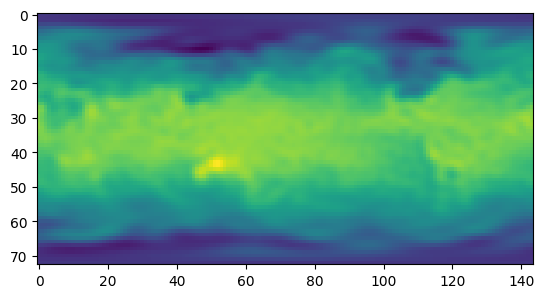

In [ ]:
plt.imshow(test_labels[0,...,0])

7/7 [==============================] - 1s 122ms/step


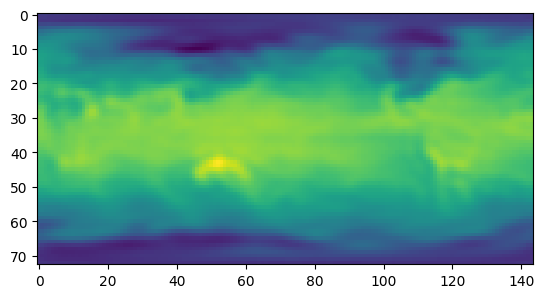

In [ ]:
plt.imshow(model.predict(test_data)[0,...,0])

In [ ]:
best_model = tf.keras.models.load_model('best_model.h5', compile=False)

In [ ]:
best_model.predict(tf.reshape(test_data[0], [1,73,144,1]))[0].shape

1/1 [==============================] - 0s 19ms/step


(73, 144, 1)

1/1 [==============================] - 0s 20ms/step


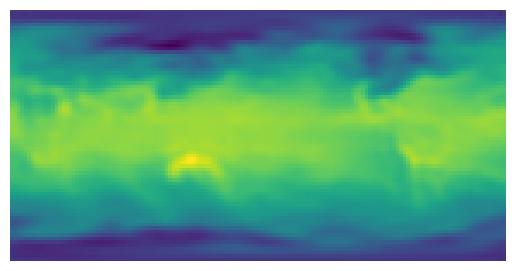

In [ ]:
plt.imshow(best_model.predict(tf.reshape(test_data[0], [1,73,144,1]))[0,...,0])
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step


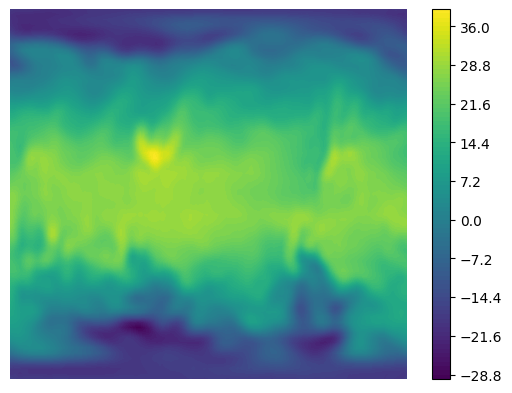

In [ ]:
plt.contourf(best_model.predict(tf.reshape(test_data[0], [1,73,144,1]))[0,...,0], levels=100)
plt.colorbar()
plt.axis('off')
plt.show()

Abs error

1/1 [==============================] - 0s 21ms/step


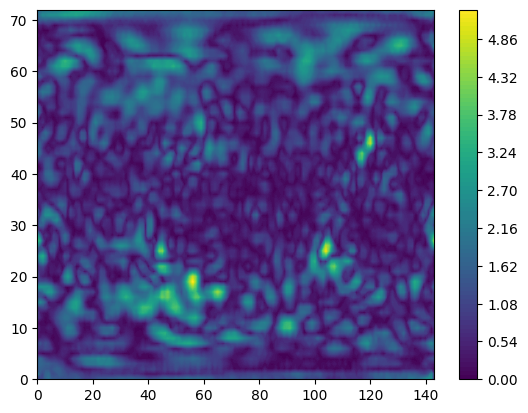

In [ ]:
plt.contourf(np.abs(test_labels[0,...,0]-best_model.predict(tf.reshape(test_data[0], [1,73,144,1]))[0,...,0]), levels=100)
plt.colorbar()

In [ ]:
import imageio

In [ ]:
test_labels.shape

(199, 73, 144, 1)

In [ ]:
# Crear una lista para almacenar las imágenes de los subplots
images = []

# Generar los subplots y guardar cada imagen en la lista
for i in np.random.randint(0, 199, 20):
    # Crear subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Primer subplot: Imagen de etiquetas de prueba con barra de color
    im1 = axs[0].contourf(test_labels[i, ..., 0], cmap='viridis', levels=100)
    axs[0].axis('off')
    axs[0].set_title('Real State')
    fig.colorbar(im1, ax=axs[0])  # Añadir la barra de color al subplot

    # Segundo subplot: Imagen generada por el modelo con barra de color
    im2 = axs[1].contourf(best_model.predict(tf.reshape(test_data[i], [1, 73, 144, 1]))[0, ..., 0], cmap='viridis', levels=100)
    axs[1].axis('off')
    axs[1].set_title('Predicted')
    fig.colorbar(im2, ax=axs[1])  # Añadir la barra de color al subplot

    # Ajustar el espaciado entre subplots
    plt.tight_layout()

    # Guardar la imagen actual en la lista
    plt.savefig(f"subplot_{i}.png")  # Guardar cada subplot con un nombre de archivo único

    # Cerrar la figura para evitar superposición de imágenes
    plt.close(fig)

    # Agregar la imagen actual a la lista de imágenes
    images.append(imageio.imread(f"subplot_{i}.png"))

# Guardar las imágenes como un GIF animado
imageio.mimsave("subplots.gif", images, duration=1)  # Ajusta la duración según tus preferencias


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Revisar gif generado